In [1]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Input, Flatten, Dropout, LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import random
from keras.applications import EfficientNetB0
import pandas as pd
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", "use_inf_as_na")

rs = 7284

np.random.seed(rs)
random.seed(rs)
tf.random.set_seed(rs)

# Load Data

Using subset I created with 50 species and 100 images each for the train data, and 5 each for the val and test data. Code for creating that dataset is in my 'brendon_test_file' codebook, but a couple notes on that:

- One of the birds that got selected was "Looney Birds" which are...not birds. I manually replaced that one with "HORNED GUAN"
- Toucan was mispelled as "Touchan" so I renamed that file. 

In [2]:
# Set file path for loading data
train_dir = './birds/train'
val_dir = "./birds/valid"
test_dir = "./birds/test"

In [3]:
# Set the number of images per bird to include
num_img = 100
num_birds = 20

# Instantiate the containers for holding image and label data
train_data = []
val_data = []
test_data = []

bird_num = 0
# Load train data
for i in os.listdir(train_dir):
    bird_num +=1
    if bird_num > num_birds:
        break
    count = 0
    sub_directory = os.path.join(train_dir, i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > num_img:
            break
        img = cv2.imread(os.path.join(sub_directory, j))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        train_data.append([img, i])
    
            
bird_num = 0
# Load validation data
for i in os.listdir(val_dir):
    bird_num += 1
    if bird_num > num_birds:
        break
    sub_directory = os.path.join(val_dir, i)
    for j in os.listdir(sub_directory):
        img = cv2.imread(os.path.join(sub_directory, j))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        val_data.append([img, i])

bird_num = 0
#Load test data
for i in os.listdir(test_dir):
    bird_num += 1
    if bird_num > num_birds:
        break
    sub_directory = os.path.join(test_dir, i)
    for j in os.listdir(sub_directory):
        img = cv2.imread(os.path.join(sub_directory, j))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        test_data.append([img, i])

print(len(train_data))
print(len(val_data))
print(len(test_data))

2000
100
100


In [4]:
bird_names = os.listdir(train_dir)[:num_birds]

In [5]:
# Check if all images are the same shape

count_t = 0
count_v = 0

for t in train_data:
    if t[0].shape != (224, 224, 3):
        count_t += 1
    
for v in val_data:
    if v[0].shape != (224, 224, 3):
        count_v += 1

print(f'There are {count_t} images of different shape in the train data.\nThere are {count_v} images of different shape in the validation data.')
    

There are 0 images of different shape in the train data.
There are 0 images of different shape in the validation data.


# Explore Data

Just looking at the first bird from each fo the 50 species we can already see that, even ignoring that they are different birds, there is a lot of variation in the images. Birds are in dfferent poses, some are just headshots while others are full body, and some are against solid backgrounds while others have landscape. Thsi could potentially be useful since this will give our model lots of diversity to learn from, but without looking through all 5000 photos, we can't know if some of the birds are more diverse than others and so our model will be able to learn them better. 

There are also a few instances where I suspect the model will struggle to differentiate, for instance the Great Xenops and Cedar Waxwing appear to be pretty similar, unless there are more distinctive photos in our training set, it may struggle to learn how to tell those apart.

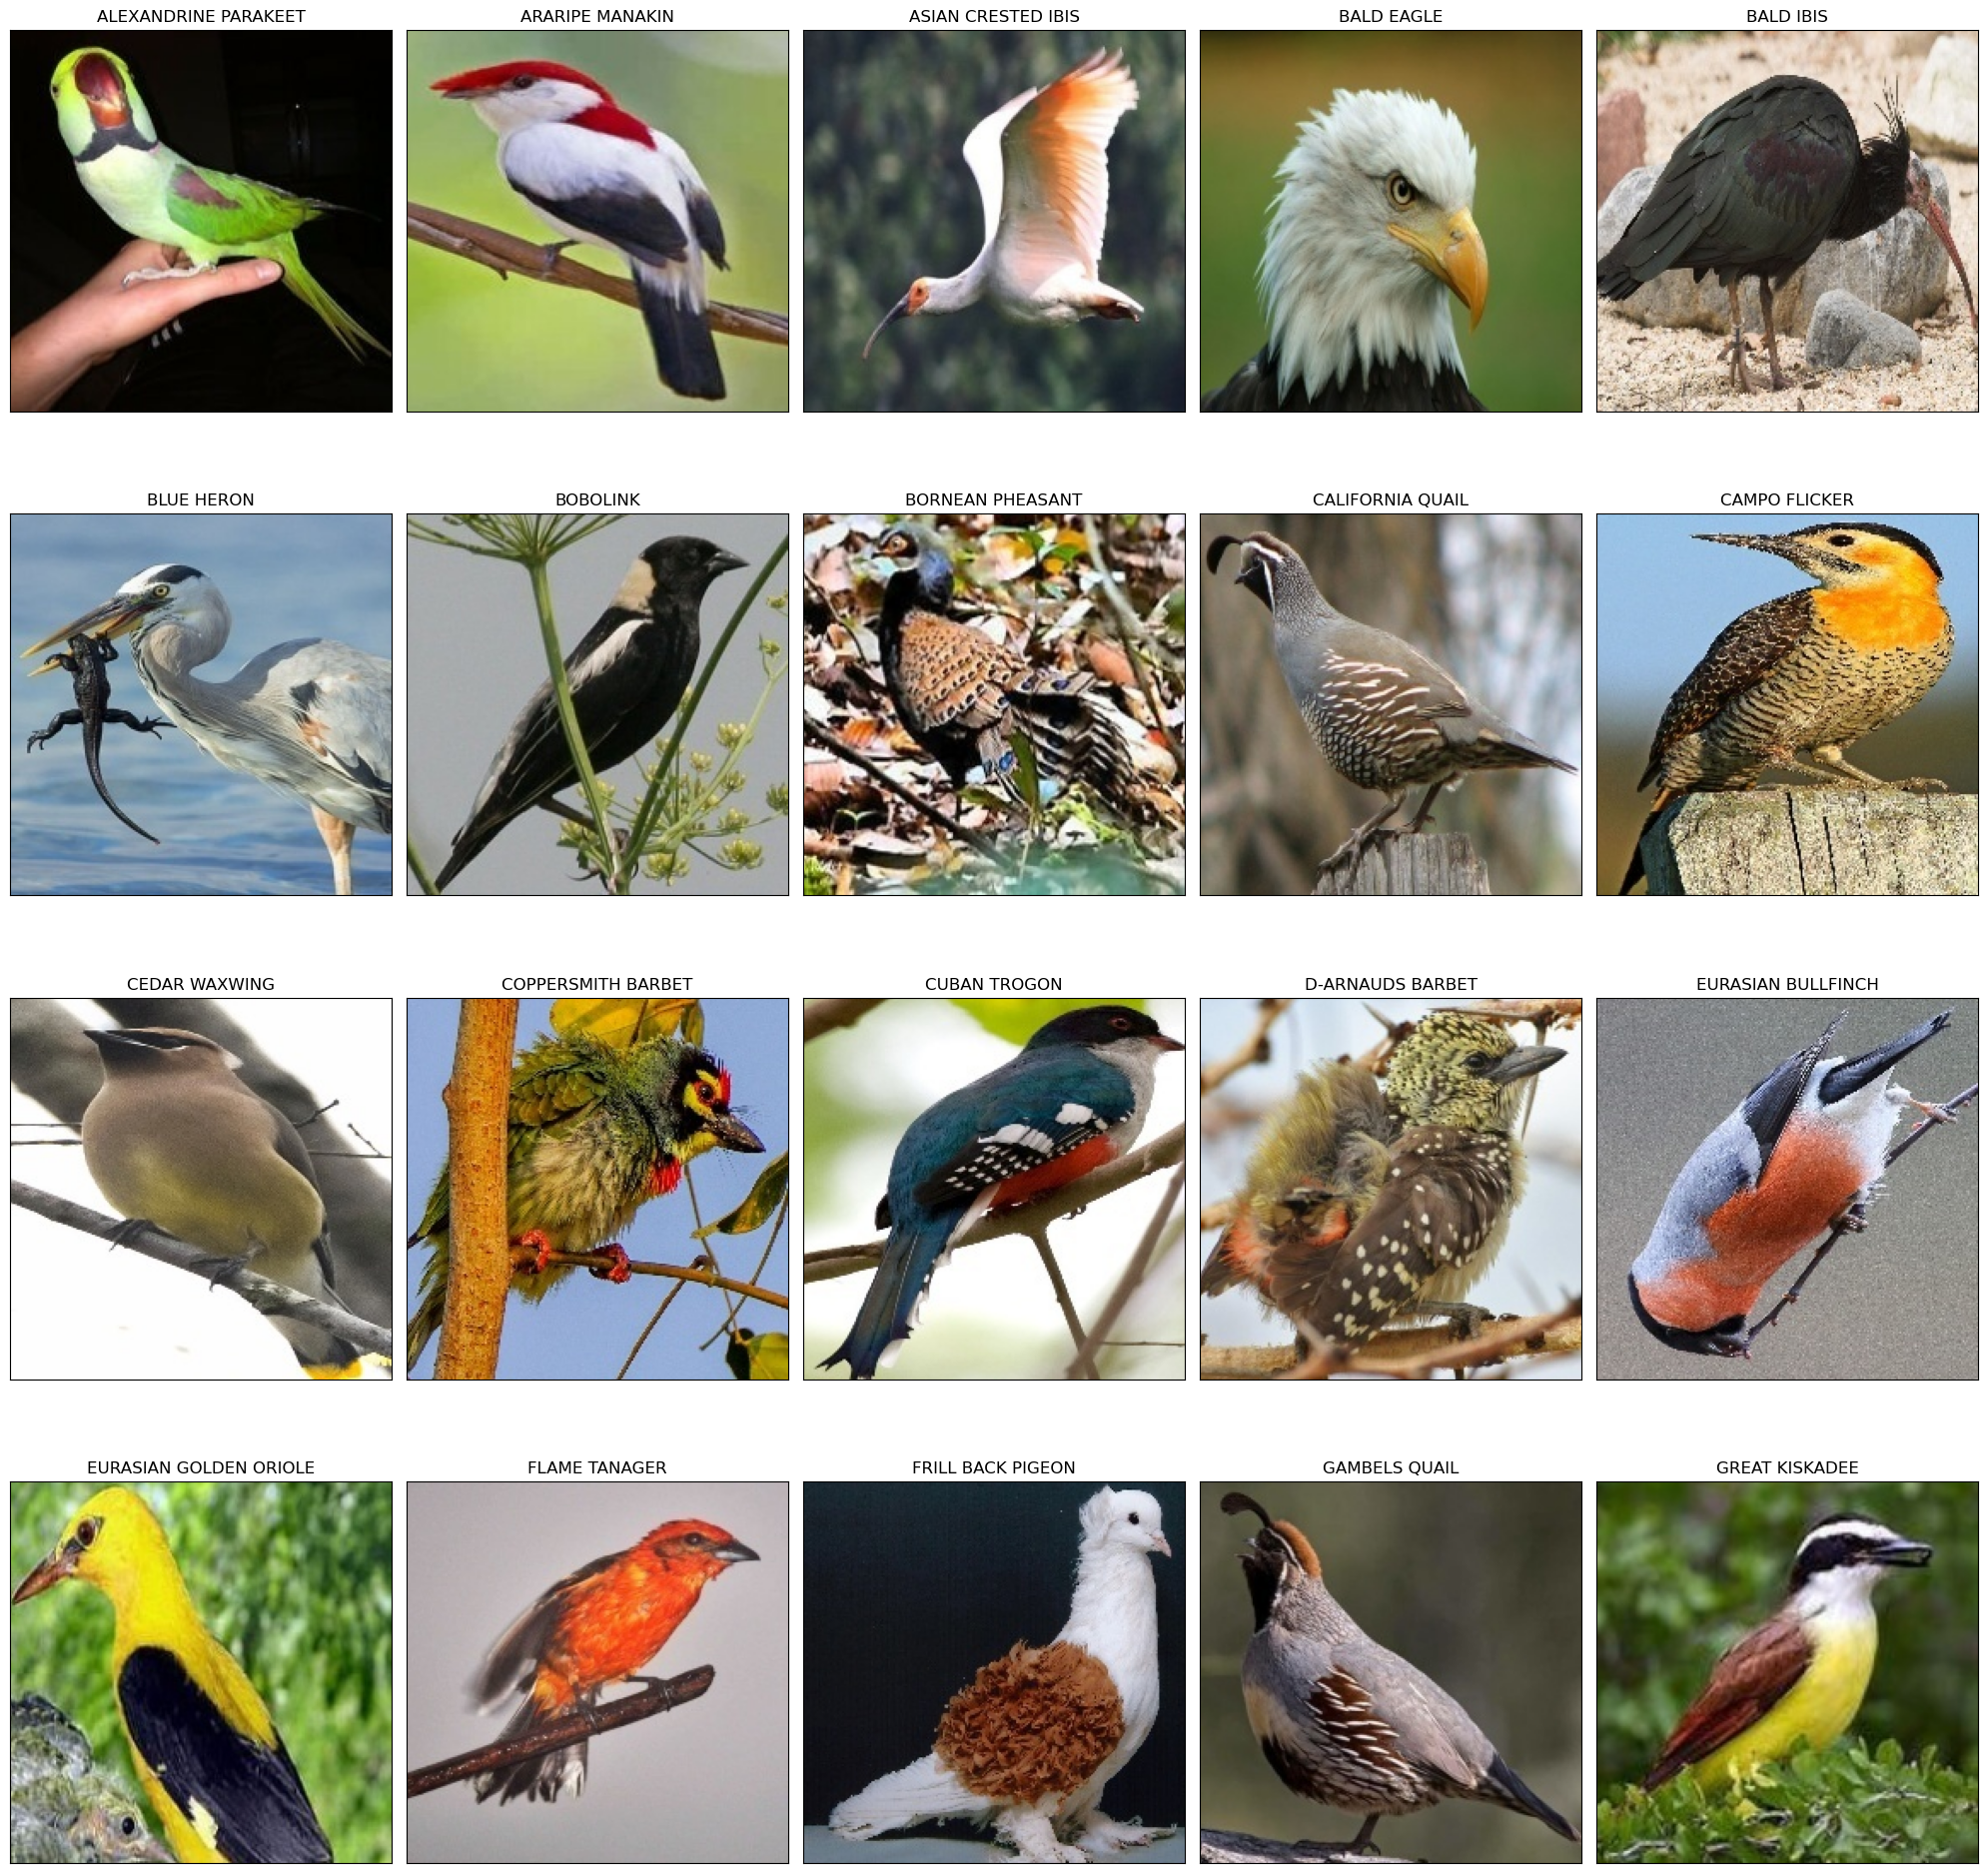

In [6]:
# Show an image for each bird
fig, axs = plt.subplots(int(num_birds/5), 5, figsize=(20, 20))

axs = axs.ravel()

ax = 0
for idx in np.arange(0, num_birds*num_img, num_img):
    bird = train_data[idx][1]
    img = train_data[idx][0]
    axs[ax].xaxis.set_ticks([])
    axs[ax].yaxis.set_ticks([])
    axs[ax].set_title(bird)
    # Note that cv2 reads images in BGR, but plt.imshow is expecting RGB, cvtColor reverses the channels so the correct color is shown when plotted. 
    axs[ax].imshow(img)
    ax +=1

plt.tight_layout()
plt.show()

# Preapre Data for Training

In [7]:
# Shuffle data to randomize batches

np.random.seed(rs)
np.random.shuffle(train_data)
np.random.shuffle(val_data)

In [8]:
# Preprocess training data and validation data
lb = LabelBinarizer()

X_train = []
y_train = []
for x, y in train_data:
    X_train.append(x)
    y_train.append(y)

X_train = np.array(X_train)
y_train = np.array(y_train)

y_train_vect = lb.fit_transform(y_train)

X_val = []
y_val = []
for x, y in val_data:
    X_val.append(x)
    y_val.append(y)

X_val = np.array(X_val)
y_val = np.array(y_val)

y_val_vect = lb.fit_transform(y_val)

# Model Set Up

In [62]:
def set_callbacks(filename, patience= 8, start_from_eopch= 10):
    stopping = EarlyStopping(monitor= 'val_accuracy', patience= 8, start_from_epoch=10, restore_best_weights= True)
    checkpoint = ModelCheckpoint(filename, monitor = 'val_accuracy', save_best_only= True)

    return stopping, checkpoint

def plot_loss (mod_hist):

    '''Plots the loss and accuracy for model training'''

    results_df = pd.DataFrame({'Train Accuracy': mod_hist.history['accuracy'],
                           'Val Accuracy': mod_hist.history['val_accuracy'],
                           'Train Loss': mod_hist.history['loss'],
                           'Val Loss': mod_hist.history['val_loss']
                           })

    fig, axs = plt.subplots(ncols=2, figsize = (12, 4))

    sns.lineplot(results_df['Val Loss'], ax= axs[0], label = 'Val Loss')
    sns.lineplot(results_df['Train Loss'], ax= axs[0], label = 'Train Loss')

    sns.lineplot(results_df['Val Accuracy'], ax= axs[1], label = 'Val Acc')
    sns.lineplot(results_df['Train Accuracy'], ax= axs[1], label = 'Train Acc')

    # axs[1].set_yticks(np.arange(.1, 1.01, .05))
    # axs[0].set_yticks(np.arange(0, 5.1, .2))

    plt.legend()

    plt.show()

def model_setup(rs=7284):
    '''Clears keras global state to save memory and then sets the 3 seeds necessary for consistency in keras'''
    
    # keras.backend.clear_session()

    np.random.seed(rs)
    random.seed(rs)
    tf.random.set_seed(rs)
    
def resize_img(X_train ,X_val, new_size):
    '''Resizes an array of images

        Args:
            X_train (array): Array of image data for training
            X_val (array): Array of img data for validation
            new_size (tuple): The shape to resize the images to

        Returns:
            X_train_rs (array): An array of the same length as X_train with images resized
            X_val_rs (array): An array of the same length as X_val with images resized

    '''
    X_train_rs = []
    X_val_rs = []

    #Resize training data
    for img in X_train:
        rsimg = cv2.resize(img, new_size)
        X_train_rs.append(rsimg)

    X_train_rs = np.array(X_train_rs)

    # Resize validation data
    for img in X_val:
        rsimg = cv2.resize(img, new_size)
        X_val_rs.append(rsimg)

    X_val_rs = np.array(X_val_rs)

    return X_train_rs, X_val_rs

# Run predicitons on validation set and create DF to compare results
def prediction_eval(model):

    predictions = np.argmax(model.predict(X_val), axis=1)

    y_hat = np.array([bird_names[i] for i in predictions])

    pred_eval_df = pd.DataFrame({'y_true': y_val,
                                'y_hat': y_hat
                                })

    # Look at number of correct predictions for each bird
    pred_eval_df['Correct'] = pred_eval_df.apply(lambda x: 0 if x['y_true'] != x['y_hat'] else 1, axis= 1)

    correct_count = pd.DataFrame(pred_eval_df.groupby(by='y_true').sum()['Correct'])

    return correct_count

# Simple Model

In [11]:
warnings.filterwarnings("ignore", "tensorflow")

model_setup()

inputs = Input(shape=(224, 224, 3))

cnn1 = Conv2D(32, 3, activation="leaky_relu")(inputs)

pool1 = MaxPooling2D(2)(cnn1)

flat = Flatten()(pool1)

predictions = Dense(num_birds, activation='softmax')(flat)

simp_model = Model(inputs=inputs, outputs=predictions)

simp_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 20)                7885460   
                                                                 
Total params: 7886356 (30.08 MB)
Trainable params: 7886356 (30.08 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [12]:
stopping, checkpoint = set_callbacks('simple_model.keras')

simp_model.compile(optimizer='RMSProp', loss= 'categorical_crossentropy', metrics=['accuracy'])

simp_history = simp_model.fit(x = X_train/255, y= y_train_vect, batch_size=128, validation_data= (X_val/255, y_val_vect), verbose = 0, epochs = 100, callbacks=[stopping, checkpoint])

simp_model.evaluate(X_val/255, y_val_vect)




4/4 [==============================] - 0s 21ms/step - loss: 0.8571 - accuracy: 0.8100


[0.8571308851242065, 0.8100000023841858]

In [13]:
pred_df = prediction_eval(simp_model)

pred_df.sort_values(by='Correct')

1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 19ms/step


Correct
y_true                         
BALD EAGLE                    0
BLUE HERON                    1
BALD IBIS                     2
CAMPO FLICKER                 3
FLAME TANAGER                 3
BOBOLINK                      3
EURASIAN GOLDEN ORIOLE        3
EURASIAN BULLFINCH            3
D-ARNAUDS BARBET              3
CEDAR WAXWING                 3
FRILL BACK PIGEON             4
ALEXANDRINE PARAKEET          4
CALIFORNIA QUAIL              4
BORNEAN PHEASANT              4
ARARIPE MANAKIN               4
GREAT KISKADEE                4
CUBAN TROGON                  5
GAMBELS QUAIL                 5
ASIAN CRESTED IBIS            5
COPPERSMITH BARBET            5

# Model Complexity Test

I tried a ton of different combinations and this one worked the best, it gave me the best accuracy and was one of the few ones that didn't 100% misclassify something (usually bald eagles) I think this is the best one for the next step. 

In [92]:
warnings.filterwarnings("ignore", "tensorflow")

keras.backend.clear_session()
model_setup()

inputs = Input(shape=(224, 224, 3))

cnn1 = Conv2D(64, 3, activation="leaky_relu")(inputs)

pool1 = MaxPooling2D(2)(cnn1)

cnn2 = Conv2D(32, 3, activation="leaky_relu")(pool1)

pool3 = MaxPooling2D(2)(cnn2)

cnn3 = Conv2D(32, 3, activation='leaky_relu')(pool3)

pool2 = MaxPooling2D(2)(cnn3)

dp1 = Dropout(.5)(pool2)

flat = Flatten()(dp1)

dense1 = Dense(256, activation='leaky_relu')(flat)

predictions = Dense(num_birds, activation='softmax')(dense1)

comp_model = Model(inputs=inputs, outputs=predictions)

comp_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        9248  

In [93]:
stopping, checkpoint = set_callbacks('complex_model.keras')

comp_model.compile(optimizer='rmsprop', loss= 'categorical_crossentropy', metrics=['accuracy'])

comp_history = comp_model.fit(x = X_train/255, y= y_train_vect, batch_size=128, validation_data= (X_val/255, y_val_vect), verbose = 1, epochs = 100, callbacks=[stopping, checkpoint])

comp_model.evaluate(X_val/255, y_val_vect)

Epoch 1/100
16/16 [==============================] - 19s 1s/step - loss: 4.5957 - accuracy: 0.0610 - val_loss: 2.8309 - val_accuracy: 0.1700
Epoch 2/100
16/16 [==============================] - 19s 1s/step - loss: 2.7755 - accuracy: 0.1860 - val_loss: 2.4529 - val_accuracy: 0.2500
Epoch 3/100
16/16 [==============================] - 20s 1s/step - loss: 2.6087 - accuracy: 0.2540 - val_loss: 2.2746 - val_accuracy: 0.2900
Epoch 4/100
16/16 [==============================] - 20s 1s/step - loss: 2.0392 - accuracy: 0.4035 - val_loss: 1.7925 - val_accuracy: 0.4600
Epoch 5/100
16/16 [==============================] - 19s 1s/step - loss: 1.6046 - accuracy: 0.5300 - val_loss: 1.3234 - val_accuracy: 0.6100
Epoch 6/100
16/16 [==============================] - 19s 1s/step - loss: 1.2775 - accuracy: 0.6140 - val_loss: 1.1829 - val_accuracy: 0.6200
Epoch 7/100
16/16 [==============================] - 20s 1s/step - loss: 0.9165 - accuracy: 0.7125 - val_loss: 0.9320 - val_accuracy: 0.7000
Epoch 8/100
1

[296.9852600097656, 0.7599999904632568]

In [94]:
comp_model.evaluate(X_val/255, y_val_vect)

4/4 [==============================] - 0s 43ms/step - loss: 0.7382 - accuracy: 0.8500


[0.7381826639175415, 0.8500000238418579]

4/4 [==============================] - 0s 56ms/step - loss: 1.2178 - accuracy: 0.8100


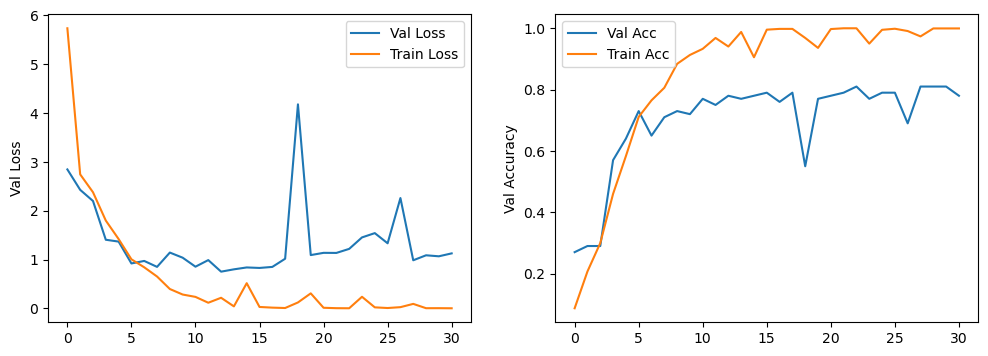

4/4 [==============================] - 0s 56ms/step


Correct
y_true                         
BALD EAGLE                    1
BALD IBIS                     1
D-ARNAUDS BARBET              2
FLAME TANAGER                 3
BLUE HERON                    3
BOBOLINK                      3
COPPERSMITH BARBET            3
ALEXANDRINE PARAKEET          4
FRILL BACK PIGEON             4
CEDAR WAXWING                 4
CAMPO FLICKER                 4
GAMBELS QUAIL                 4
CALIFORNIA QUAIL              5
CUBAN TROGON                  5
BORNEAN PHEASANT              5
EURASIAN BULLFINCH            5
EURASIAN GOLDEN ORIOLE        5
ASIAN CRESTED IBIS            5
ARARIPE MANAKIN               5
GREAT KISKADEE                5

In [114]:


plot_loss(history1)

pred_df = prediction_eval(comp_model)

pred_df.sort_values(by='Correct')

# Progressive Resizing Experiment

## 56x56

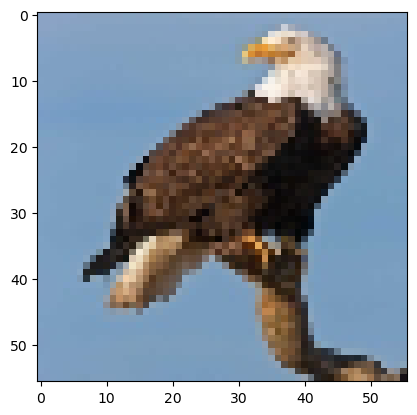

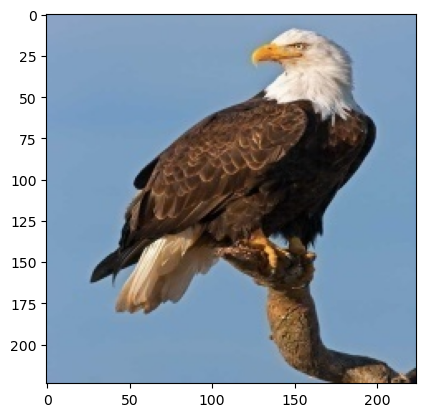

In [65]:
# Resize imags to 56x56

X_train_56, X_val_56 = resize_img(X_train, X_val, (56, 56))

# Compare to original data
plt.imshow(X_train_56[5])
plt.show()

plt.imshow(X_train[5])
plt.show()

In [66]:
# Just running a couple epochs on baseline to validate that it should still be able to get decent results
from keras.applications import EfficientNetB0

keras.backend.clear_session()

# Load Model 
enet = EfficientNetB0(include_top= False, input_shape=(56, 56, 3), weights= 'imagenet')

layers = enet.layers

for layer in layers:
    layer.trainable = False

# Add a flatten and softmax layer
base_model= Sequential([
    enet,
    Flatten(),
    Dense(num_birds, activation='softmax')
])

# Compile model
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

base_history = base_model.fit(x = X_train_56, y= y_train_vect, batch_size=80, validation_data= (X_val_56, y_val_vect), verbose = 1, epochs = 2)

Epoch 1/2
25/25 [==============================] - 6s 113ms/step - loss: 1.7438 - accuracy: 0.5135 - val_loss: 0.7104 - val_accuracy: 0.8500
Epoch 2/2
25/25 [==============================] - 2s 70ms/step - loss: 0.5888 - accuracy: 0.8470 - val_loss: 0.4890 - val_accuracy: 0.9100


In [106]:
# Create model to train 56x56 images

keras.backend.clear_session()
model_setup()

model = Sequential()

model.add(Conv2D(64, 3, activation="leaky_relu", padding= 'same', input_shape = (56, 56, 3)))

model.add(Conv2D(64, 3, activation= 'leaky_relu', padding='same'))

model.add(MaxPooling2D(2))

model.add(Conv2D(32, 3, activation="leaky_relu"))

model.add(MaxPooling2D(2))

model.add(Conv2D(32, 3, activation='leaky_relu'))

model.add(MaxPooling2D(2))

model.add(Dropout(.5))

model.add(Flatten())

model.add(Dense(256, activation='leaky_relu'))

model.add(Dense(num_birds, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 32)        9

In [107]:
# Set callbacks

stopping, checkpoint = set_callbacks('model_56.keras', patience=20)

model.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

history_56 = model.fit(x = X_train_56/255, y= y_train_vect, batch_size=128, validation_data= (X_val_56/255, y_val_vect), verbose = 1, epochs = 100, callbacks=[checkpoint])

model.evaluate(X_val_56/255, y_val_vect)

Epoch 1/100
16/16 [==============================] - 4s 217ms/step - loss: 2.9896 - accuracy: 0.0685 - val_loss: 2.8958 - val_accuracy: 0.1300
Epoch 2/100
16/16 [==============================] - 4s 238ms/step - loss: 2.8305 - accuracy: 0.1455 - val_loss: 2.5729 - val_accuracy: 0.2800
Epoch 3/100
16/16 [==============================] - 4s 261ms/step - loss: 2.4834 - accuracy: 0.2400 - val_loss: 2.2163 - val_accuracy: 0.3000
Epoch 4/100
16/16 [==============================] - 4s 249ms/step - loss: 2.2665 - accuracy: 0.2975 - val_loss: 2.0259 - val_accuracy: 0.4200
Epoch 5/100
16/16 [==============================] - 4s 251ms/step - loss: 2.0525 - accuracy: 0.3810 - val_loss: 1.7135 - val_accuracy: 0.4900
Epoch 6/100
16/16 [==============================] - 4s 252ms/step - loss: 1.8412 - accuracy: 0.4520 - val_loss: 1.5271 - val_accuracy: 0.5500
Epoch 7/100
16/16 [==============================] - 4s 259ms/step - loss: 1.7046 - accuracy: 0.4750 - val_loss: 1.5060 - val_accuracy: 0.5100

[0.7958962917327881, 0.8399999737739563]

In [113]:
model_56 = keras.saving.load_model('model_56.keras')

model_56.evaluate(X_val_56/255, y_val_vect)

4/4 [==============================] - 0s 14ms/step - loss: 0.4895 - accuracy: 0.9000


[0.4894619286060333, 0.8999999761581421]

## 112x112

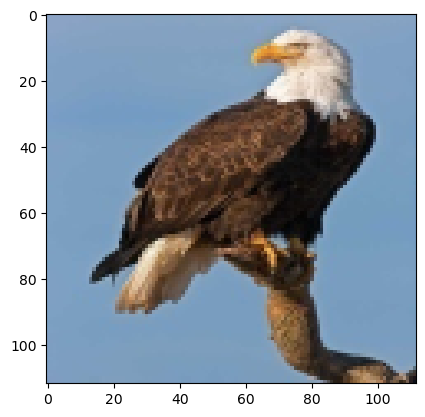

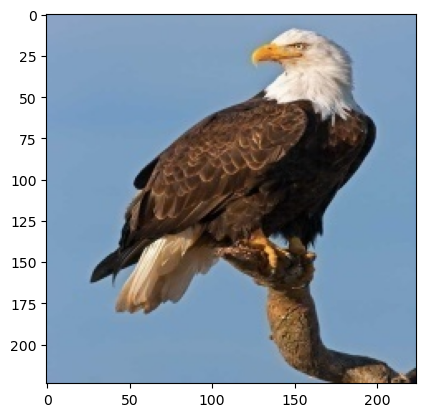

In [108]:
# Resize imags to 112x112

X_train_112, X_val_112 = resize_img(X_train, X_val, (112, 112))

# Compare to original data
plt.imshow(X_train_112[5])
plt.show()

plt.imshow(X_train[5])
plt.show()

## Images at 224

Resizing up to 112 didn't improve accuracy anymore than 56 did, so I'm just layering the 224 model on top of the 56 model.

In [131]:
model_setup()

model = Sequential()

model.add(Conv2D(128, 3, padding='same', activation='leaky_relu', input_shape=(224, 224, 3)))

model.add(MaxPooling2D(2))

model.add(Conv2D(64, 3, padding='same', activation='leaky_relu'))

model.add(MaxPooling2D(2))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 224, 224, 128)     3584      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 112, 112, 64)      73792     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                                           
                                                                 
Total params: 77376 (302.25 KB)
Trainable params: 77376 (302.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [132]:
model_56 = keras.saving.load_model('model_56.keras')

# Check size of model:
print(f'End model has {len(model_56.layers)} layers\n')

# Check input sizes for first two layers
for layer in model_56.layers[:2]:
    print(layer.input)

# Add all layers except for input layer to the new model
for layer in model_56.layers[1:]:
    model.add(layer)

# Lock weights for model_56 layers
for layer in model.layers[-10:]:
    layer.trainable = False

model.summary()

End model has 11 layers

KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 3), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")
KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 64), dtype=tf.float32, name=None), name='conv2d/LeakyRelu:0', description="created by layer 'conv2d'")
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 224, 224, 128)     3584      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 112, 112, 64)      73792     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 

In [133]:
# Set callbacks

stopping, checkpoint = set_callbacks('model_224.keras')

model.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

history_112 = model.fit(x = X_train/255, y= y_train_vect, batch_size=128, validation_data= (X_val/255, y_val_vect), verbose = 1, epochs = 100, callbacks=[checkpoint])

Epoch 1/100
16/16 [==============================] - 60s 4s/step - loss: 4.1603 - accuracy: 0.4535 - val_loss: 1.5267 - val_accuracy: 0.5200
Epoch 2/100
16/16 [==============================] - 58s 4s/step - loss: 0.6974 - accuracy: 0.7835 - val_loss: 0.8865 - val_accuracy: 0.7400
Epoch 3/100
16/16 [==============================] - 58s 4s/step - loss: 0.5382 - accuracy: 0.8290 - val_loss: 0.6466 - val_accuracy: 0.8200
Epoch 4/100
16/16 [==============================] - 58s 4s/step - loss: 0.2074 - accuracy: 0.9385 - val_loss: 0.7674 - val_accuracy: 0.7700
Epoch 5/100
16/16 [==============================] - 58s 4s/step - loss: 0.3786 - accuracy: 0.8830 - val_loss: 0.5981 - val_accuracy: 0.8100
Epoch 6/100
16/16 [==============================] - 60s 4s/step - loss: 0.1639 - accuracy: 0.9505 - val_loss: 0.5221 - val_accuracy: 0.8500
Epoch 7/100
16/16 [==============================] - 61s 4s/step - loss: 0.4702 - accuracy: 0.8890 - val_loss: 0.4324 - val_accuracy: 0.8300
Epoch 8/100
1

In [134]:
model_112 = keras.saving.load_model('model_112.keras')

model_112.evaluate(X_val_112/255, y_val_vect)

4/4 [==============================] - 1s 154ms/step - loss: 0.4855 - accuracy: 0.8800


[0.4854530692100525, 0.8799999952316284]

# Exploratory Code

Looking at the predictions, it looks like only 3 of our bird species are being correctly predicted 100%. The rest are somewhere in between 80% and 0%, with Bald Eagle being misclassified 100% of the time. I'll take a look at these images to see if I can get any insight into why this may be the case. 

In [ ]:
worst_bird = 'BALD EAGLE'
# List the indexes for the worst bird correctly and incorrectly predicted and show images
wrong_bird = list(pred_eval_df[(pred_eval_df['y_true'] == worst_bird) & (pred_eval_df['y_hat'] != worst_bird)].index)
right_bird = list(pred_eval_df[(pred_eval_df['y_true'] == worst_bird) & (pred_eval_df['y_hat'] == worst_bird)].index)


print(f'Incorrectly labeled {worst_bird}')
fig, axs = plt.subplots(ncols=len(wrong_bird), figsize = (15, 5))

for idx, i in enumerate(wrong_bird):

    axs[idx].imshow(X_val[i])
    axs[idx].xaxis.set_ticks([])
    axs[idx].xaxis.set_ticks([])
    axs[idx].set_title(pred_eval_df['y_hat'][i])

plt.tight_layout()
plt.show()

if len(right_bird) > 0: 

    print(f'Correctly labeled {worst_bird}')

    fig, axs = plt.subplots(ncols=len(right_bird), figsize = (10, 5))

    for idx, i in enumerate(right_bird):

        axs.imshow(X_val[i])
        axs.xaxis.set_ticks([])
        axs.xaxis.set_ticks([])
        axs.set_title(pred_eval_df['y_hat'][i])
        
    plt.tight_layout()
    plt.show()

In [ ]:
# Look at first 5 examples of images from the training set for blue herons and misclassified birds
birds = ['BALD EAGLE', 'ASIAN CRESTED IBIS', 'GAMBELS QUAIL', 'FRILL BACK PIGEON']

for bird in birds:
    fig, axs = plt.subplots(ncols=5, figsize = (20, 5))

    bird_imgs = X_train[y_train == bird][:5]

    for idx, b in enumerate(bird_imgs):

        axs[idx].imshow(b)
        axs[idx].xaxis.set_ticks([])
        axs[idx].xaxis.set_ticks([])
        
    fig.suptitle(bird)
    plt.tight_layout()
    plt.show()

One possible challenge is that the bald eagle validation set appears to be almost entirely headshots, while the testing set is more mixed, so it may be having trouble identifying that it's just a head. 

For other birds, based on this sample, the Asian Crested Ibis could be pictured flying more which might explain the confusion with the first picture, but otherwise these seem to be a little all over the place. This isn't surprising since the model is so simple, it's not going to have much opportunity to differentiate features so it's likely making pretty broad sweeps on features which is why it's confusing bald eagle so much. 

I am going to add mroe complexity to the model by adding a second fully connected layer ahead of teh softmax layer, and increse teh node sizes on the CNN to 32

In [ ]:
model_setup()

inputs = Input(shape=(224, 224, 3))

cnn1 = Conv2D(32, 3, activation= 'relu')(inputs)

pool1 = MaxPooling2D(2)(cnn1)

dp1 = Dropout(.2)(pool1)

flat = Flatten()(dp1)

dense1 = Dense(128, activation='relu')(flat)

predictions = Dense(num_birds, activation='softmax')(dense1)

model = Model(inputs=inputs, outputs=predictions)

model.summary()

In [ ]:
model.compile(optimizer='RMSProp', loss= 'categorical_crossentropy', metrics=['accuracy'])

history2 = model.fit(x = X_train/255, y= y_train_vect, batch_size=128, validation_data= (X_val/255, y_val_vect), verbose = 1, epochs = 100, callbacks= [stopping, checkpoint])

In [ ]:
plot_loss(history2)

As I suspected, even with the dropout layers, adding more complexity has overfit our model a bit too much actually resulting in worse generalizability. 

2 fairly standard solutions to overfitting are adding more data or reducing the complexity fo teh model. While I do have more data, that feels like it's going to make the problem too easy, so I'm going to just pretend I don't. As for reducing model complexity, our model is already very simple so it's going to be hard to reduce the model complexity without making it a worse model.

Instead, I'm going to try a different technique that will reduce the complexity of the data rather than the complexity of the model to see if we can get the model to learn more general features. This technique is progressive resizing, where we shrink our data down to a smaller size and then incrementally train the model on larger and larger sizes until we've built it back up to the original image size. In theory, this could help the model generalize more by not overlearning the noise in the larger images.

We'll shrink our images down to 28x28 and then double them back up until we are back to the original 224x224 size.

In [ ]:
# Resize images

X_train_28, X_val_28 = resize_img(X_train= X_train, X_val= X_val, new_size=(28, 28))

# Examine a couple instances
img= X_train_28[15]
img2= X_train_28[150]

plt.imshow(img)
plt.show()

plt.imshow(img2)
plt.show()

In [ ]:
keras.backend.clear_session()
# Create model for 28x28 images
model_setup()

model = Sequential()

model.add(Conv2D(32, 3, activation= 'leaky_relu', input_shape = (28, 28, 3), padding='same'))

model.add(Conv2D(32, 3, activation= 'leaky_relu', padding='same'))

model.add(MaxPooling2D(2))

model.add(Dropout(.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(num_birds, activation='softmax'))

model.summary()

Because the data is so small now, I can drop the early stopping part, increase the epochs, and just use the model checkpoint to save the best version of the model.

In [ ]:
checkpoint = ModelCheckpoint('model_28.keras', monitor='val_accuracy', save_best_only= True)
stopping = EarlyStopping(monitor= 'val_accuracy', patience= 50, restore_best_weights=True)

model.compile(optimizer='RMSProp', loss= 'categorical_crossentropy', metrics=['accuracy'])

history3 = model.fit(x = X_train_28/255, y= y_train_vect, batch_size=128, validation_data= (X_val_28/255, y_val_vect), verbose = 1, epochs = 800, callbacks=[checkpoint, stopping])

In [ ]:
plot_loss(history3)